In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from tqdm import tqdm
from gbi_diff.dataset.simulator_api import TwoMoonsSimulator
from gbi_diff.dataset.simulators.linear_gaussian import LinearGaussianSimulator


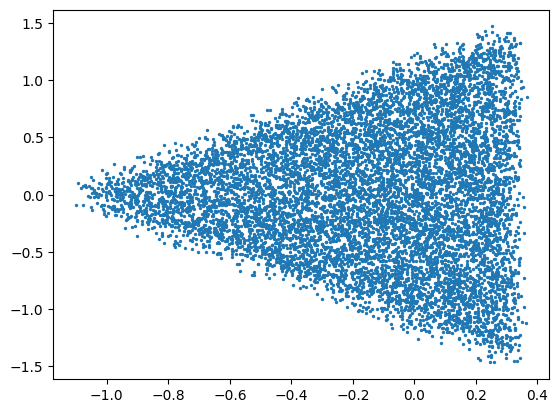

In [ ]:

def generate_two_moons(n, n_target):
    simulator = TwoMoonsSimulator()
    theta = simulator.sample_prior(n)
    x = simulator.sample(theta)
    theta_target = simulator.sample_prior(n_target)
    x_target = simulator.sample(theta_target)
    return theta, x, x_target


def generate_linear_gaussian(n, n_target):
    simulator = LinearGaussianSimulator()
    theta = simulator.prior.sample(n)
    x = simulator.simulate(theta)
    theta_target = simulator.prior.sample(n_target)
    x_target = simulator.simulate(theta_target)
    return theta, x, x_target
    


generate_data = generate_two_moons
theta, x, x_target = generate_data(10000, 100)
plt.scatter(*x.T, s=2)
plt.show()

In [15]:
def get_positional_encoding(t: np.ndarray, d: int = 512, n: int=10_000) -> np.ndarray:
    """get positional encoding for a time vector t

    Args:
        t (np.ndarray): time indices. Integers >= 0 with shape (n_samples, )
        d (int, optional): dimension of the final positional encoding. Has to be an even number Defaults to 512. 
        n (int, optional): User defined scalar. Defaults to 10_000.

    Returns:
        np.ndarray: (n_samples, d)
    """
    n_samples = len(t)
    pos_enc = np.zeros((n_samples, d))
    
    pos_index = np.arange(d // 2)
    denominator = np.power(n, 2 * pos_index / d)

    pos_enc[:, 2*pos_index] = np.sin(t[:, None] / denominator[None])
    pos_enc[:, 2*pos_index + 1] = np.cos(t[:, None] / denominator[None])

    return pos_enc

In [37]:
def dist_matrix(x, x_target):
    return torch.mean(torch.square(x[:, None] - x_target[None]), dim=-1, keepdim=True)

dist_matrix(x, x_target).shape

torch.Size([10000, 100, 1])

In [26]:
T = 1000  # Number of diffusion timesteps
beta_start = 1e-4
beta_end = 0.02

n = 1000
n_target = 20
t_dim = 64

# Compute beta, alpha, and alpha_bar
betas = torch.zeros(T + 1)
betas[1:] = torch.linspace(beta_start, beta_end, T)
alphas = 1.0 - betas
alphas_bar = torch.cumprod(alphas, dim=0)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/robin/miniconda3/envs/gbi/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1, 1000, 20, 1])) that is different to the input size (torch.Size([1000, 20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 10000/10000 [02:15<00:00, 73.75it/s]


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

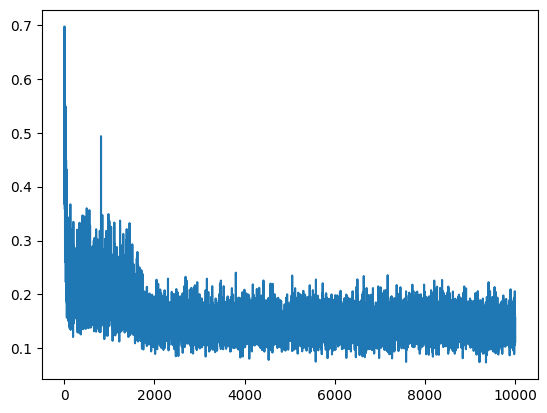

In [ ]:
guidance = nn.Sequential(
    nn.Linear(2 + t_dim + 2, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 32),
    nn.SiLU(),
    nn.Linear(32, 1),
)
guidance_criterion = nn.MSELoss()
guidance_optimizer = torch.optim.AdamW(guidance.parameters(), lr=0.0004)


train_loss = []
val_loss = []

n_epochs = 10000
for epoch in tqdm(range(n_epochs)):
    theta_train, x_train, x_target_train = generate_data(n, n_target)
    t = torch.from_numpy(np.random.choice(T, size=len(theta_train)))
    alpha_bar = alphas_bar[t, None]

    noise_t = torch.normal(0, 1, size=(theta_train.shape))
    theta_t = np.sqrt(alpha_bar) * theta_train + np.sqrt(1 - alpha_bar) * noise_t
    pos_enc = torch.from_numpy(get_positional_encoding(t.numpy(), d=t_dim)).float()
    
    theta_t = theta_t[:, None].repeat((1, n_target, 1))
    pos_enc = pos_enc[:, None].repeat((1, n_target, 1))
    x_target_train = x_target_train[None].repeat((n, 1, 1))
    inp = torch.cat([theta_t, x_target_train, pos_enc], dim=2).float()
    
    y_hat = guidance(inp)
    loss = guidance_criterion.forward(y_hat, dist_matrix(x_train, x_target_train))
    guidance_optimizer.zero_grad()
    loss.backward()
    guidance_optimizer.step()

    train_loss.append(loss.item())
    
val_loss = torch.tensor(val_loss)
plt.plot(train_loss, label="train loss")
plt.legend()
plt.show()

In [ ]:
# shapes:
# theta_train: (n, param_dim)
# x_train: (n, obs_dim)
# x_target_train: (n_target, param_dim)
theta_train, x_train, x_target_train = generate_data(n=1000, n_target=10000)

t = torch.zeros(len(theta_train), dtype=int)
alpha_bar = alphas_bar[t, None]

noise_t = torch.normal(0, 1, size=(theta_train.shape))
theta_t = np.sqrt(alpha_bar) * theta_train + np.sqrt(1 - alpha_bar) * noise_t
pos_enc = torch.from_numpy(get_positional_encoding(t.numpy(), d=t_dim)).float()

theta_t = theta_t[:, None].repeat((1, len(x_target_train), 1))
pos_enc = pos_enc[:, None].repeat((1, len(x_target_train), 1))
x_target_train_rep = x_target_train[None].repeat((len(theta_train), 1, 1))
inp = torch.cat([theta_t, x_target_train_rep, pos_enc], dim=2).float()

y_hat = guidance(inp).detach().numpy().flatten()

plt.scatter(*x_target_train.T, c=y_hat)
plt.scatter(*x_target_train[np.argmin(y_hat)])
plt.scatter(*x_train[0], color="r")

RuntimeError: [enforce fail at alloc_cpu.cpp:118] err == 0. DefaultCPUAllocator: can't allocate memory: you tried to allocate 25600000000 bytes. Error code 12 (Cannot allocate memory)